# **Actividad 2.1: Regresión Logística y Validación Cruzada**

**Base de datos obtenida de:** https://www.kaggle.com/datasets/marius2303/nissan-all-models-price-prediction-dataset

**Objetivo:** Realizar un modelo predictivo para la variable precio (que expresa a cuánto se puede revender un carro basado en sus caracteristicas) que describa cómo las varibales numéricas afectarían a esta variable si fuera categórica binaria.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
#Importar libreria para dividir los datos en training | test
from sklearn.model_selection import train_test_split
#Regresión logistica
from sklearn.linear_model import LogisticRegression
#Matriz de confusión
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay as cmd
#Curva ROC y AUC
from sklearn.metrics import roc_curve, auc

In [ ]:
url= 'https://raw.githubusercontent.com/AdrianaPS03/Nissan_Price_Prediction/refs/heads/main/nissan-dataset.csv'
df = pd.read_csv(url)
print('Información relevante de la base de datos:\n')
print('Cantidad de variables: ', df.shape[1])
print('Cantidad de observaciones: ', df.shape[0])
print('Tipos de variables:\n', df.dtypes)
print('Varibel de interes: ', df.columns[9])
print('\nMuestra de los primeros 5 datos\n')
df.head()

Información relevante de la base de datos:

Cantidad de variables:  10
Cantidad de observaciones:  10000
Tipos de variables:
 id               int64
full_name       object
age            float64
gender          object
model           object
color           object
performance    float64
km             float64
condition       object
price          float64
dtype: object
Varibel de interes:  price

Muestra de los primeros 5 datos



,id,full_name,age,gender,model,color,performance,km,condition,price
0,1,Dominic Applin,42.0,Male,Quest,Mauv,299.0,509305.0,very bad,40394.91
1,2,Lenee Eteen,54.0,Polygender,R'nessa,Orange,109.0,965853.0,old,8687.90
2,3,Kendal Esselin,37.0,Male,March / Micra,Teal,52.0,380906.0,bad,44705.31
3,4,Nehemiah Marvelley,55.0,Male,Gloria,Green,336.0,573171.0,very good,32889.88
4,5,Domenic McGeouch,21.0,Male,Avenir,Khaki,2.0,809470.0,old,6949.22


Realmente no es necesario conservar variables como full_name o id para calcular el precio, así como tampoco son necesarias las caracteristicas del vendedor, ya que queremos centrarnos en el auto y el precio por el que se vendería, por lo que primero, y antes de realizar cualquier análisis, vamos a eliminar estas columnas innecesarias.


In [ ]:
df.drop(columns=['id', 'full_name', 'age', 'gender'], inplace=True)
#Eliminar datos vacios ya que estamos
df = df[['model', 'color', 'km', 'performance', 'condition', 'price']].dropna(axis=0)
df.head()

,model,color,km,performance,condition,price
0,Quest,Mauv,509305.0,299.0,very bad,40394.91
1,R'nessa,Orange,965853.0,109.0,old,8687.90
2,March / Micra,Teal,380906.0,52.0,bad,44705.31
3,Gloria,Green,573171.0,336.0,very good,32889.88
4,Avenir,Khaki,809470.0,2.0,old,6949.22


Ya que lo que queremos es determinar una salida binaria con un modelo de clasificación, primero debemos convertir la variable 'price' de numérica a categórica. Debido a que buscamos solo 1 y 0 dividiremos los precios de acuerdo a la media (que en este caso se parece mucho al promedio, por lo que podemos usar cualquiera de las dos con resultados similares).
<p>Todo aquello por encima de la media será considerado un auto que se puede vender a 'buen precio' (1), y todo lo que esté debajo será considerado un auto que se puede vender a un 'menor precio' (0).</p>

In [ ]:
print('Mediana:', df['price'].median())
print('Promedio:', df['price'].mean())
#Función hecha con ayuda de ChatGPT
def categorize_price(price):
    if price >= df['price'].median():
        return 1
    else:
        return 0
df['price_category'] = df['price'].apply(categorize_price)
df.head()

Mediana: 27328.295
Promedio: 27357.144300044092


,model,color,km,performance,condition,price,price_category
0,Quest,Mauv,509305.0,299.0,very bad,40394.91,1
1,R'nessa,Orange,965853.0,109.0,old,8687.90,0
2,March / Micra,Teal,380906.0,52.0,bad,44705.31,1
3,Gloria,Green,573171.0,336.0,very good,32889.88,1
4,Avenir,Khaki,809470.0,2.0,old,6949.22,0


Ahora rápidamente convirtamos las varibales categóricas (que no son la dependiente) en variables numéricas. En este caso 'condition', 'model' y 'color'. En este caso convertiremos todas con 'One-Hot Encoding' sin importar cuantas columnas más nos generen.

In [ ]:
dummyCondition = pd.get_dummies(df.condition, drop_first=True, dtype=int)
dummyModel = pd.get_dummies(df.model, drop_first=True, dtype=int)
dummyColor = pd.get_dummies(df.color, drop_first=True, dtype=int)
df = pd.concat([df, dummyCondition, dummyModel, dummyColor], axis=1)
df = df.drop(columns=['condition', 'model', 'color'])
df.head()

,km,performance,price,price_category,good,new,old,very bad,very good,AD,...,Pink,Puce,Purple,Red,Silver,Teal,Turquoise,Violet,White,Yellow
0,509305.0,299.0,40394.91,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,965853.0,109.0,8687.90,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,380906.0,52.0,44705.31,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,573171.0,336.0,32889.88,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,809470.0,2.0,6949.22,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Ahora que tenemos nuestra base de datos lista para usarse comenzaremos por dividir los datos en entrenamiento y validación.
<p>Todas las vairbales dentro de la base de datos podrían ser interesantes de análizar en un modelo de clasificación, pero para mantener el modelo simple y sencillo de interpretar utilizaremos las más interesantes.</p>
<p>Personalmente considero que es importante tomar en cuenta el kilometraje y los caballos de fuerza de un auto y la condición en la que está cuando se trata de determinar el precio al que se puede vender una vez usado. Esto nos da un total de 6 variables: 'km', 'performance', 'good', 'new', 'old', 'very bad', 'very good'. Pero usemos solo las variables de la condición del auto que no tienen que ver con el tiempo, esto nos deja con la siguiente información: 'km', 'performance', 'good', 'very bad', 'very good'.</p>
<p>Para el modelo también es importante considerar el balance de los datos, que en este caso quedó perfectamente balanceado, así que al hacer la partición en entrenamiento y validación debemos asegurar que se manetenga de esta forma.</p>

In [ ]:
print('Balance de la base de datos completa:')
print(df['price_category'].value_counts())
x = df[['km', 'performance', 'good', 'very bad', 'very good']]
y = df['price_category']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)
print('Balance de los datos de entrenamiento:')
print(y_train.value_counts())
print('Balance de los datos de validación:')
print(y_test.value_counts())

Balance de la base de datos completa:
price_category
1    4536
0    4536
Name: count, dtype: int64
Balance de los datos de entrenamiento:
price_category
1    3629
0    3628
Name: count, dtype: int64
Balance de los datos de validación:
price_category
0    908
1    907
Name: count, dtype: int64


Podemos ver que en todas las particiones se mantiene un balance similar a la base de datos orginal.
<p>Ahora generemos el modelo de regresión logística con nuestros datos de entrenamiento y probemos qué tan exacto es con los datos de validación.</p>

In [ ]:
model = LogisticRegression(penalty=None, class_weight='balanced').fit(x_train,y_train)
pred = model.predict(x_test)
acc = np.mean(pred == y_test)
print('Exactitud o desempeño del modelo: ')
print(acc)

Exactitud o desempeño del modelo: 
0.5146005509641873


El modelo tiene un desempeño aproximado del 51%, es decir, predice de forma correcta el 51% de las observaciones. No es un buen modelo, pues si acierta o no es básicamente un 50/50, pero ahora observemos métricas más específicas que nos puedan describir mejor el comportamiento del modelo. Para esto calcularemos la sensibilidad y la especificidad através de una mátriz de confusión.

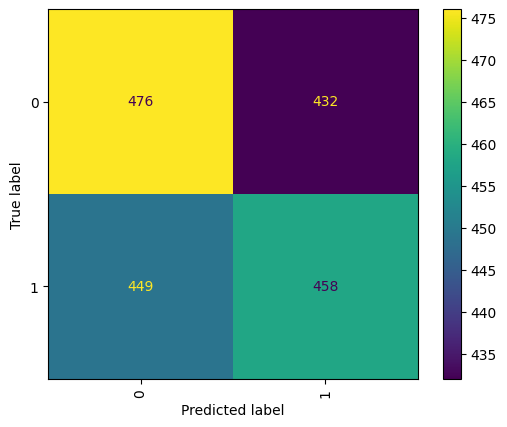

In [ ]:
#Vector de probabilidades
y_probs = model.predict_proba(x_test)[:, 1]
#Matriz de confusión
cm = confusion_matrix(y_test, pred)
#sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
cmd(cm,display_labels=model.classes_).plot(xticks_rotation="vertical")

Podemos tomar la mátriz anterior como una mala señal, ya que el modelo básicamente está haciendo predicciones tan buenas como predicciones al azar. El 50% de las veces predice un 1 como 1 y el otro 50% lo clasifica como 0. Esto podría significar que la probabilidad que el modelo encuentra para cada dato es exactamente 50% todas las veces o muy cercana a este número, lo cual es inconveniente ya que no es un modelo exacto sino un modelo que predice 0 y 1 al azar.
<p>Probemos cambiar el umbral y ver qué sucede. De esta forma podemos comprobar que tan lejos o cerca están las probabilidades del 50%.</p>

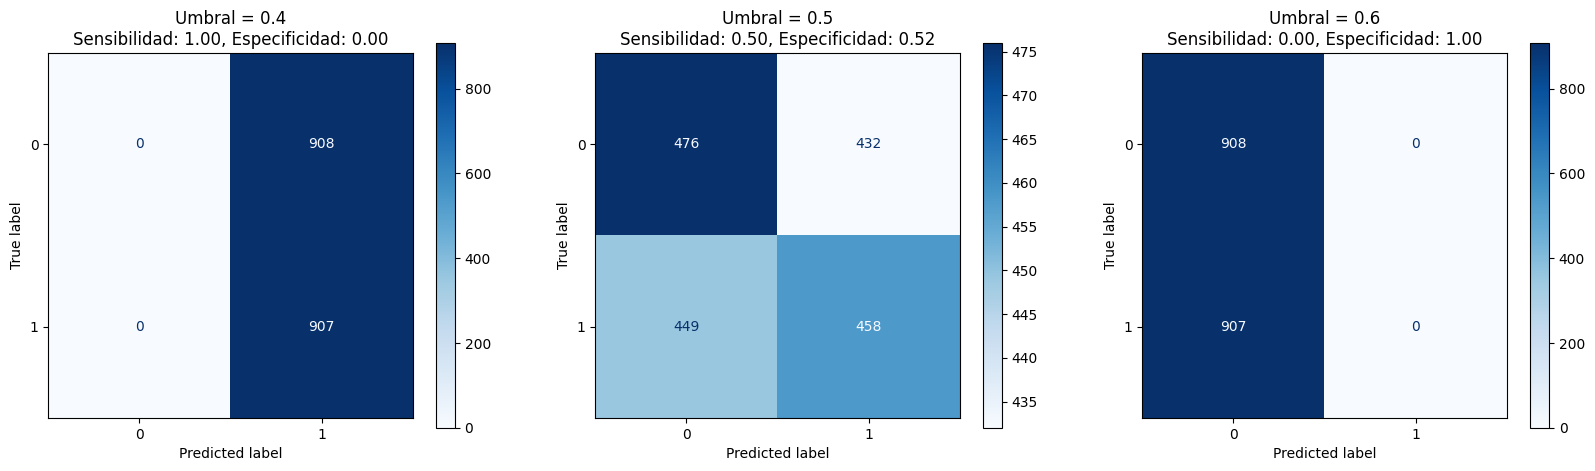

In [ ]:
thresholds = [0.4, 0.5, 0.6]
#Código obtenido con ayuda de ChatGPT
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for i, threshold in enumerate(thresholds):
    y_pred = (y_probs >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)

    # Extraer TN, FP, FN, TP de la matriz de confusión
    TN, FP, FN, TP = cm.ravel()

    # Calcular sensibilidad y especificidad
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    disp = cmd(cm, display_labels=[0, 1])
    disp.plot(ax=axes[i], cmap="Blues")
    axes[i].set_title(f'Umbral = {threshold}\nSensibilidad: {sensitivity:.2f}, Especificidad: {specificity:.2f}')

plt.show()

Gracias a las matrices anteriores podemos determinar que la probabilidad que el modelo está dando a los datos es muy cercana al 50%, por lo menos un 10% más cercana.
<p>Intentemos probar si es cierto acercando más el umbral.</p>

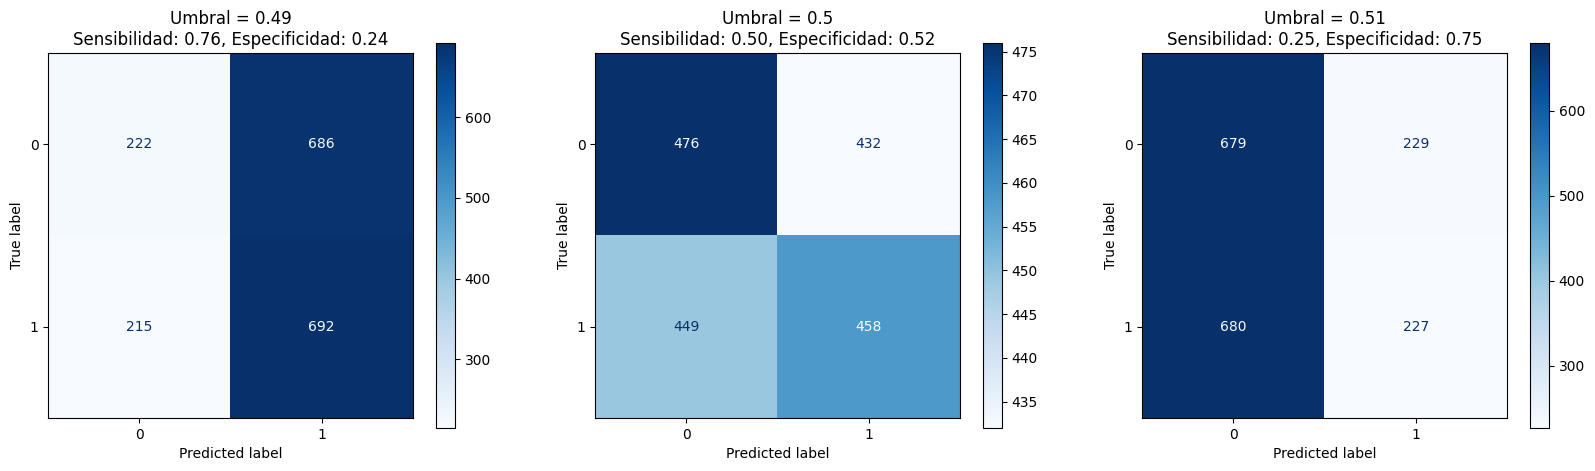

In [ ]:
thresholds = [0.49, 0.5, 0.51]
#Código obtenido con ayuda de ChatGPT
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for i, threshold in enumerate(thresholds):
    y_pred = (y_probs >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)

    # Extraer TN, FP, FN, TP de la matriz de confusión
    TN, FP, FN, TP = cm.ravel()

    # Calcular sensibilidad y especificidad
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    disp = cmd(cm, display_labels=[0, 1])
    disp.plot(ax=axes[i], cmap="Blues")
    axes[i].set_title(f'Umbral = {threshold}\nSensibilidad: {sensitivity:.2f}, Especificidad: {specificity:.2f}')

plt.show()

Acercando el umbral tenemos que, efectivamente, el modelo predice cosas muy cercanas al 50% y, por ende, sus predicciones son tan exactas como lanzar una moneda al aire. Cambiando ligeramente el umbra, nos quedamos con modelos que predicen 76% de los 0 como 0 o el 75% de los 1 como 1.

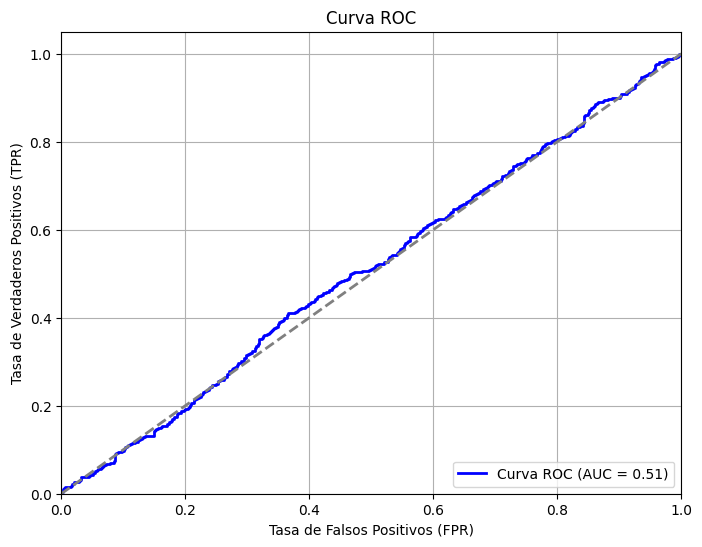

In [ ]:
#Código hecho con ayuda de ChatGPT
# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_probs)

# Calcular el área bajo la curva (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Línea de referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Con la gráfica anterior es mucho más simple observar el desempeño en cada umbral. Viendolo así, es claro que el modelo no cuenta con capacidad de discriminación, y esto lo sabemos ya que el valor del área bajo la curva es 0.51 (el mismo valor de exactitud que habiamos calculado antes), el cual nos dice que este modelo es muy similar a un clasificador aleatorio.
<p>Tomndo en cuenta lo anterior, es probable que las variables tomadas para este modelo no sean las ideales, o bien la forma de clasificar el precio en dos grupos es la incorrecta. Sería conveniente probar distintas variables que aporten mejor información al modelo, quizá realizar un selector de caracteristicas, pues ahora mismo no pareciera que ninguna variable ayude mucho a tomar una decisión.</p>
<p>Igualmente se podría partir los datos de una forma distinta, por ejemplo con un precio que se considere caro al vender un auto en el mercado del mundo real. Todo lo que este en ese nivel o arriba es un 1 y todo lo que esté abajo es un 0. De esta forma podriamos probar si la partición de datos en realidad afecto mucho al modelo.</p>

### *Doy mi palabra de que he realizado esta actividad con integridad académica.*